# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


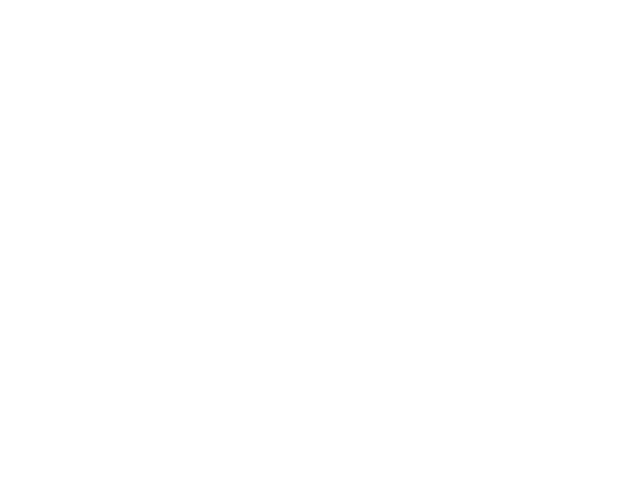

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


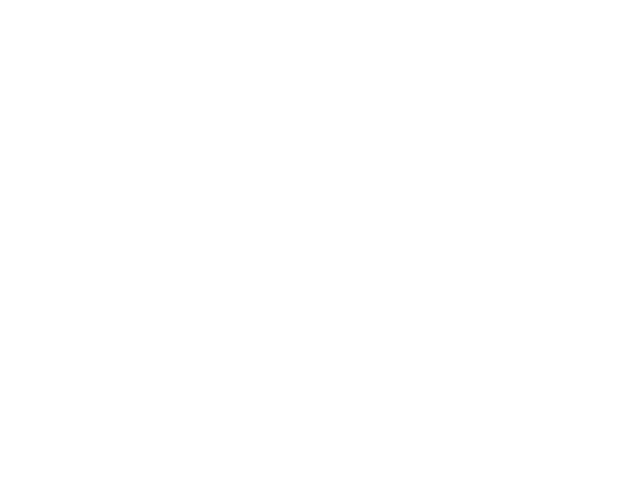

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


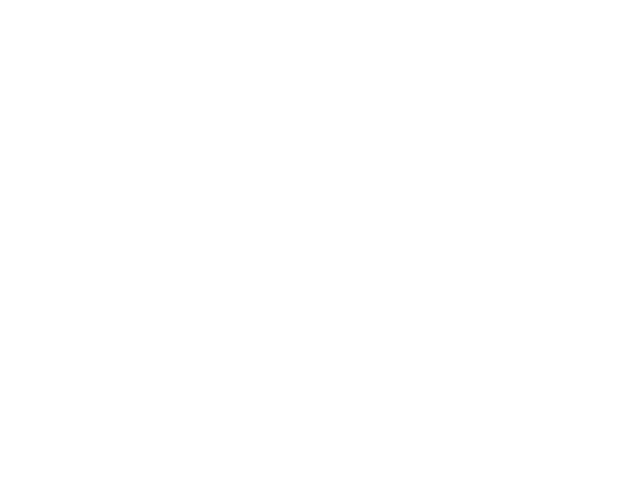

In [23]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


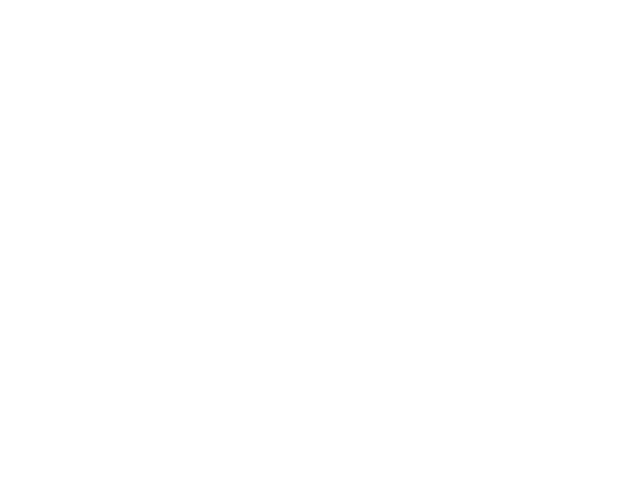

In [24]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [25]:
%matplotlib notebook

In [26]:
#   https://github.com/MSingh3012/Red-Black-tree-in-python/blob/master/RBTree.py
#   Red Black Tree implementaion in Python
#   Created By Manpreet Singh
#

import string

BLACK = 0
RED = 1

class RBNode(object):

    def __init__(self, key = None, value = None, color = RED):
        self.left = self.right = self.parent = None
        self.color = color
        self.key = key
        self.value = value
        self.nonzero = 1

    def __str__(self):
        return repr(self.key) + ': ' + repr(self.value)

    def __nonzero__(self):
        return self.nonzero

    def __len__(self):
        """imitate sequence"""
        return 2

    def __getitem__(self, index):
        """imitate sequence"""
        if index==0:
            return self.key
        if index==1:
            return self.value
        raise IndexError('only key and value as sequence')


class RBTreeIter(object):

    def __init__ (self, tree):
        self.tree = tree
        self.index = -1  # ready to iterate on the next() call
        self.node = None
        self.stopped = False

    def __iter__ (self):
        """ Return the current item in the container
        """
        return self.node.value

    def next (self):
        """ Return the next item in the container
            Once we go off the list we stay off even if the list changes
        """
        if self.stopped or (self.index + 1 >= self.tree.__len__()):
            self.stopped = True
            raise StopIteration
        #
        self.index += 1
        if self.index == 0:
            self.node = self.tree.firstNode()
        else:
            self.node = self.tree.nextNode (self.node)
        return self.node.value


class RBTree(object):

    def __init__(self,):
        self.sentinel = RBNode()
        self.sentinel.left = self.sentinel.right = self.sentinel
        self.sentinel.color = BLACK
        self.sentinel.nonzero = 0
        self.root = self.sentinel
        self.count = 0

    def __len__(self):
        return self.count

    def __del__(self):
        # unlink the whole tree

        s = [ self.root ]

        if self.root is not self.sentinel:
            while s:
                cur = s[0]
                if cur.left and cur.left != self.sentinel:
                    s.append(cur.left)
                if cur.right and cur.right != self.sentinel:
                    s.append(cur.right)
                cur.right = cur.left = cur.parent = None
                cur.key = cur.value = None
                s = s[1:]

        self.root = None
        self.sentinel = None

    def __str__(self):
        return "<RBTree object>"

    def __repr__(self):
        return "<RBTree object>"

    def __iter__ (self):
        return RBTreeIter (self)

    def rotateLeft(self, x):

        y = x.right

        # establish x.right link
        x.right = y.left
        if y.left != self.sentinel:
            y.left.parent = x

        # establish y.parent link
        if y != self.sentinel:
            y.parent = x.parent
        if x.parent:
            if x == x.parent.left:
                x.parent.left = y
            else:
                x.parent.right = y
        else:
            self.root = y

        # link x and y
        y.left = x
        if x != self.sentinel:
            x.parent = y

    def rotateRight(self, x):

        #***************************
        #  rotate node x to right
        #***************************

        y = x.left

        # establish x.left link
        x.left = y.right
        if y.right != self.sentinel:
            y.right.parent = x

        # establish y.parent link
        if y != self.sentinel:
            y.parent = x.parent
        if x.parent:
            if x == x.parent.right:
                x.parent.right = y
            else:
                x.parent.left = y
        else:
            self.root = y

        # link x and y
        y.right = x
        if x != self.sentinel:
            x.parent = y

    def insertFixup(self, x):
        #************************************
        #  maintain Red-Black tree balance  *
        #  after inserting node x           *
        #************************************

        # check Red-Black properties

        while x != self.root and x.parent.color == RED:

            # we have a violation

            if x.parent == x.parent.parent.left:

                y = x.parent.parent.right

                if y.color == RED:
                    # uncle is RED
                    x.parent.color = BLACK
                    y.color = BLACK
                    x.parent.parent.color = RED
                    x = x.parent.parent

                else:
                    # uncle is BLACK
                    if x == x.parent.right:
                        # make x a left child
                        x = x.parent
                        self.rotateLeft(x)

                    # recolor and rotate
                    x.parent.color = BLACK
                    x.parent.parent.color = RED
                    self.rotateRight(x.parent.parent)
            else:

                # mirror image of above code

                y = x.parent.parent.left

                if y.color == RED:
                    # uncle is RED
                    x.parent.color = BLACK
                    y.color = BLACK
                    x.parent.parent.color = RED
                    x = x.parent.parent

                else:
                    # uncle is BLACK
                    if x == x.parent.left:
                        x = x.parent
                        self.rotateRight(x)

                    x.parent.color = BLACK
                    x.parent.parent.color = RED
                    self.rotateLeft(x.parent.parent)

        self.root.color = BLACK

    def insert(self, key):
        #**********************************************
        #  allocate node for data and insert in tree  *
        #**********************************************

        # find where node belongs
        current = self.root
        parent = None
        while current != self.sentinel:
            # GJB added comparison function feature
            # slightly improved by JCG: don't assume that ==
            # is the same as self.__cmp(..) == 0
            # rc = self.__cmp(key, current.key)
            if key == current.key:
                return current
            parent = current
            if key < current.key:
                current = current.left
            else:
                current = current.right

        # setup new node
        x = RBNode(key, None)
        x.left = x.right = self.sentinel
        x.parent = parent

        self.count = self.count + 1

        # insert node in tree
        if parent:
            if key < parent.key:
                parent.left = x
            else:
                parent.right = x
        else:
            self.root = x

        self.insertFixup(x)
        return x

    def deleteFixup(self, x):
        #************************************
        #  maintain Red-Black tree balance  *
        #  after deleting node x            *
        #************************************

        while x != self.root and x.color == BLACK:
            if x == x.parent.left:
                w = x.parent.right
                if w.color == RED:
                    w.color = BLACK
                    x.parent.color = RED
                    self.rotateLeft(x.parent)
                    w = x.parent.right

                if w.left.color == BLACK and w.right.color == BLACK:
                    w.color = RED
                    x = x.parent
                else:
                    if w.right.color == BLACK:
                        w.left.color = BLACK
                        w.color = RED
                        self.rotateRight(w)
                        w = x.parent.right

                    w.color = x.parent.color
                    x.parent.color = BLACK
                    w.right.color = BLACK
                    self.rotateLeft(x.parent)
                    x = self.root

            else:
                w = x.parent.left
                if w.color == RED:
                    w.color = BLACK
                    x.parent.color = RED
                    self.rotateRight(x.parent)
                    w = x.parent.left

                if w.right.color == BLACK and w.left.color == BLACK:
                    w.color = RED
                    x = x.parent
                else:
                    if w.left.color == BLACK:
                        w.right.color = BLACK
                        w.color = RED
                        self.rotateLeft(w)
                        w = x.parent.left

                    w.color = x.parent.color
                    x.parent.color = BLACK
                    w.left.color = BLACK
                    self.rotateRight(x.parent)
                    x = self.root

        x.color = BLACK

    def deleteNode(self, z):
        #****************************
        #  delete node z from tree  *
        #****************************

        if not z or z == self.sentinel:
            return

        if z.left == self.sentinel or z.right == self.sentinel:
            # y has a self.sentinel node as a child
            y = z
        else:
            # find tree successor with a self.sentinel node as a child
            y = z.right
            while y.left != self.sentinel:
                y = y.left

        # x is y's only child
        if y.left != self.sentinel:
            x = y.left
        else:
            x = y.right

        # remove y from the parent chain
        x.parent = y.parent
        if y.parent:
            if y == y.parent.left:
                y.parent.left = x
            else:
                y.parent.right = x
        else:
            self.root = x

        if y != z:
            z.key = y.key
            z.value = y.value

        if y.color == BLACK:
            self.deleteFixup(x)

        del y
        self.count = self.count - 1

    def findNode(self, key):
        #******************************
        #  find node containing data
        #******************************

        current = self.root

        while current != self.sentinel:
            # GJB added comparison function feature
            # slightly improved by JCG: don't assume that ==
            # is the same as self.__cmp(..) == 0
            #rc = self.__cmp(key, current.key)
            
            if key == current.key:
                return current
            else:
                if key < current.key:
                    current = current.left
                else:
                    current = current.right

        return None
    
    def remove(self, key):
        node = self.findNode(key)
        self.deleteNode(node)

    def traverseTree(self, f):
        if self.root == self.sentinel:
            return
        s = [ None ]
        cur = self.root
        while s:
            if cur.left:
                s.append(cur)
                cur = cur.left
            else:
                f(cur)
                while not cur.right:
                    cur = s.pop()
                    if cur is None:
                        return
                    f(cur)
                cur = cur.right
        # should not get here.
        return

    def nodesByTraversal(self):
        """return all nodes as a list"""
        result = []
        def traversalFn(x, K=result):
            K.append(x)
        self.traverseTree(traversalFn)
        return result

    def nodes(self):
        """return all nodes as a list"""
        cur = self.firstNode()
        result = []
        while(not cur is self.sentinel and not cur is None):
            result.append(cur.key)
            cur = self.nextNode(cur)
        return result

    def minimum(self):
        cur = self.root
        
        if self.root is None:
            return None
        
        while not cur.left is self.sentinel:
            cur = cur.left
            
        return cur.key

    def maximum(self):
        cur = self.root
        
        if self.root is None:
            return None
        
        while not cur.right is self.sentinel:
            cur = cur.right
            if cur is self.sentinel:
                return None
        return cur.key
    
    def firstNode(self):
        cur = self.root
        
        if self.root is None:
            return None
        
        while not cur.left is self.sentinel:
            cur = cur.left
            
        return cur
    
    def nextNode(self, prev):
        cur = prev
        
        if cur is None:
            return None
        
        if not cur.right is self.sentinel:
            cur = prev.right
            while not cur.left is self.sentinel:
                cur = cur.left
            return cur
        while 1:
            cur = cur.parent
            if cur is None or cur is self.sentinel:
                return None
            if prev.key < cur.key or prev.key == cur.key:
                return cur
    
    def successor(self, prev):
        """returns None if there isn't one"""
        prev = self.findNode(prev)
        
        cur = prev
        
        if cur is None:
            return None
        
        if not cur.right is self.sentinel:
            cur = prev.right
            while not cur.left is self.sentinel:
                cur = cur.left
            return cur.key
        while 1:
            cur = cur.parent
            if cur is None or cur is self.sentinel:
                return None
            if prev.key < cur.key or prev.key == cur.key:
                return cur.key

    def predecessor(self, next):
        """returns None if there isn't one"""
        next = self.findNode(next)
        
        cur = next
        
        if cur is None:
            return None
        
        if not cur.left is self.sentinel:
            cur = next.left
            while not cur.right is self.sentinel:
                cur = cur.right
            return cur.key
        while 1:
            cur = cur.parent
            if cur is None or cur is self.sentinel:
                return None
            if cur.key < next.key or next.key == cur.key:
                return cur.key

In [27]:
class Point:
    def __init__(self, x, y, ptype = 1):
        self.x = x
        self.y = y
        self.ptype = ptype # 1 means start, 2 intersection, 3 end
        self.other_end = None
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def to_tuple(self):
        return (self.x, self.y)
    
    def to_line_tuple(self):
        return [(self.x, self.y), (self.other_end.x, self.other_end.y)]
    
class State:
    def __init__(self, point):
        self.line_point_start = point
        self.orientation_point = point
    
    def __lt__(self, other):
        orientation = None
        if self.orientation_point.x >= other.orientation_point.x:
            orientation = orient(self.orientation_point, other.line_point_start)
        else:
            orientation = -orient(other.orientation_point, self.line_point_start)
        
        return (orientation == 1) or (orientation == 0 and orient(self.line_point_start.other_end, other.line_point_start) == 1)
        
    def __eq__(self, other):
        return self.line_point_start == other.line_point_start
    
class Event:
    def __init__(self, point, lines, event_type):
        self.point = point
        self.lines = lines
        self.type = event_type # where 1 means start, 3 means end and 2 means intersection
    
    def __lt__(self, other):
        return (self.point.x < other.point.x) or (self.point.x == other.point.x and self.point.y < other.point.y) or (self.point.x == other.point.x and self.point.y == other.point.y and self.type < other.type)
 
    def __eq__(self, other):
        return self.point == other.point and self.type == other.type

In [28]:
def det(a,b,c):
    return (a.x-c.x)*(b.y-c.y)-(b.x-c.x)*(a.y-c.y)

def orient(point, line_point_start, eps=1e-8):
    orientation = det(line_point_start, line_point_start.other_end, point)
    if(orientation < -eps):
        return -1
    elif(orientation > eps):
        return 1
    else:
        return 0

In [29]:
def intersection(a, b):
    divider = (b.other_end.x - b.x)*(a.y - a.other_end.y) - (a.x - a.other_end.x)*(b.other_end.y - b.y)
    gallantA = (b.y - b.other_end.y)*(a.x - b.x) + (b.other_end.x - b.x)*(a.y - b.y)
    gallantB = (a.y - a.other_end.y)*(a.x - b.x) + (a.other_end.x - a.x)*(a.y - b.y)
    tA = gallantA/divider
    tB = gallantB/divider
    
    if 0 <= tA and tA <= 1 and 0 <= tB and tB <= 1:
        x = a.x + tA*(a.other_end.x-a.x)
        y = a.y + tA*(a.other_end.y-a.y)
        return (x, y)

In [30]:
def isIntersection(lines):
    events = RBTree()
    state = RBTree()
    
    for line in lines:
        events.insert(Event(line, line, 1))
        events.insert(Event(line.other_end, line, 3))
    
    event = events.minimum()
    while event:
        if(event.type == 1):
            state_line = State(event.lines)
            
            state.insert(state_line)
            neighbour1 = state.successor(state_line)
            neighbour2 = state.predecessor(state_line)
            
            if neighbour1:
                intersectPoint = intersection(state_line.line_point_start, neighbour1.line_point_start)
                if intersectPoint:
                    return True
                
            if neighbour2:
                intersectPoint = intersection(state_line.line_point_start, neighbour2.line_point_start)
                if intersectPoint:
                    return True
    
        elif(event.type == 3):
            state_line = State(event.lines)
            
            neighbour1 = state.successor(state_line)
            neighbour2 = state.predecessor(state_line)
            state.remove(state_line)
            
            if neighbour2:
                intersectPoint = intersection(state_line.line_point_start, neighbour2.line_point_start)
                if intersectPoint:
                    return True
        
        events.remove(event)
        event = events.minimum()
            
    return False

In [31]:
def addIntersection(line1, line2, events, intersections):
    if line1 and line2:
        intersectPoint = intersection(line1.line_point_start, line2.line_point_start)
        if intersectPoint and intersectPoint not in intersections:
            intersections.append(intersectPoint)   
            event = Event(Point(intersectPoint[0], intersectPoint[1]), 
                          [line1.line_point_start, line2.line_point_start], 2)
            events.insert(event)
            
def BentleyOttoman(lines, raw_lines):
    events = RBTree()
    state = RBTree()
    
    scenes = []
    intersections = []
    yMin = lines[0].y if lines[0].y < lines[0].other_end.y else lines[0].other_end.y
    yMax = lines[0].y if lines[0].y > lines[0].other_end.y else lines[0].other_end.y
        
    for line in lines:
        events.insert(Event(line, line, 1))
        events.insert(Event(line.other_end, line, 3))
        if line.y < yMin:
            yMin = line.y
        if line.other_end.y < yMin:
            yMin = line.other_end.y
        if line.y > yMax:
            yMax = line.y
        if line.other_end.y > yMax:
            yMax = line.other_end.y
    
    event = events.minimum()
    while event:
        if(event.type == 1):
            state_line = State(event.lines)
            
            state.insert(state_line)
            neighbour1 = state.successor(state_line)
            neighbour2 = state.predecessor(state_line)
            addIntersection(state_line, neighbour1, events, intersections)
            addIntersection(state_line, neighbour2, events, intersections)
    
        elif(event.type == 3):
            state_line = State(event.lines)
            
            neighbour1 = state.successor(state_line)
            neighbour2 = state.predecessor(state_line)
            state.remove(state_line)
            addIntersection(neighbour1, neighbour2, events, intersections)
        else:
            state_line1 = State(event.lines[0])
            state.remove(state_line1)
            state_line1.orientation_point = event.point
            state.insert(state_line1)
            neighbour11 = state.successor(state_line1)
            neighbour12 = state.predecessor(state_line1)
            addIntersection(state_line1, neighbour11, events, intersections)
            addIntersection(state_line1, neighbour12, events, intersections)
            
            state_line2 = State(event.lines[1])
            state.remove(state_line2)
            state_line2.orientation_point = event.point
            state.insert(state_line2)
            neighbour21 = state.successor(state_line2)
            neighbour22 = state.predecessor(state_line2)
            addIntersection(state_line2, neighbour21, events, intersections)
            addIntersection(state_line2, neighbour22, events, intersections)
        
        nodes = state.nodes()
        active_lines = []
        for node in nodes:
            active_lines.append(node.line_point_start.to_line_tuple())
        
        scenes.append(Scene([PointsCollection(intersections.copy()),
                            PointsCollection([event.point.to_tuple()], color='red')], 
                            [LinesCollection(raw_lines),
                             LinesCollection(active_lines, color='yellow'),
                             LinesCollection([[(event.point.x, yMin), (event.point.x, yMax)]], color='red')]))
        
        events.remove(event)
        event = events.minimum()
    
    scenes.insert(0, Scene([PointsCollection(intersections.copy(), color='black')], 
                            [LinesCollection(raw_lines)]))
            
    return intersections, scenes

In [32]:
def checkEndingPoints(lines, point1, point2):
    for line in lines:
        if(line[0] == point1):
            return False
        if(line[1] == point2):
            return False
        
    return True

def checkIfVertical(point1, point2):
    if(point1[0] == point2[0]):
        return True
    
    return False
    
def generateLines(number_of_lines, x_range, y_range):
    Lin = []
    i = 0
    while(i < number_of_lines):
        point1 = (np.random.uniform(0, x_range), np.random.uniform(0, y_range))
        point2 = (np.random.uniform(0, x_range), np.random.uniform(0, y_range))
        if(checkEndingPoints(Lin, point1, point2) and not checkIfVertical(point1, point2)):
            if(point1[0] < point2[0]):
                Lin.append([point1, point2])
            else:
                Lin.append([point2, point1])
            i += 1
        
    return Lin

def toPointsArray(lines):
    points = []
    for line in lines:
        point1 = Point(line[0][0], line[0][1])
        point2 = Point(line[1][0], line[1][1], 3)
        points.append(point1)
        point1.other_end = point2
        point2.other_end = point1
        
    return points

In [33]:
Lin = generateLines(10, 10, 10)
#print(Lin)

In [34]:

DrawnLines = plot1.get_added_elements().lines[0].lines
#for line in DrawnLines[:]:
#    if(checkIfVertical(line[0], line[1])):
#        DrawnLines.remove(line)
        
print(DrawnLines)


[[(0.14349798387096774, 0.47652166403976143), (0.2366431451612903, 0.4495608797260359)], [(0.27656250000000004, 0.5169628405103497), (0.3697076612903226, 0.5169628405103497)], [(0.11466733870967744, 0.8404922522750555), (0.8287802419354838, 0.19006333070642806)], [(0.07918346774193546, 0.1968035267848594), (0.7711189516129032, 0.8809334287456438)], [(0.5604334677419355, 0.7629799973730946), (0.4805947580645161, 0.34845793854956525)], [(0.6180947580645162, 0.8371221542358398), (0.5382560483870967, 0.3686785267848594)]]


In [38]:
lines = toPointsArray(DrawnLines)

In [39]:
print(isIntersection(lines))
intersections, scenes = BentleyOttoman(lines, DrawnLines)

True


<IPython.core.display.Javascript object>


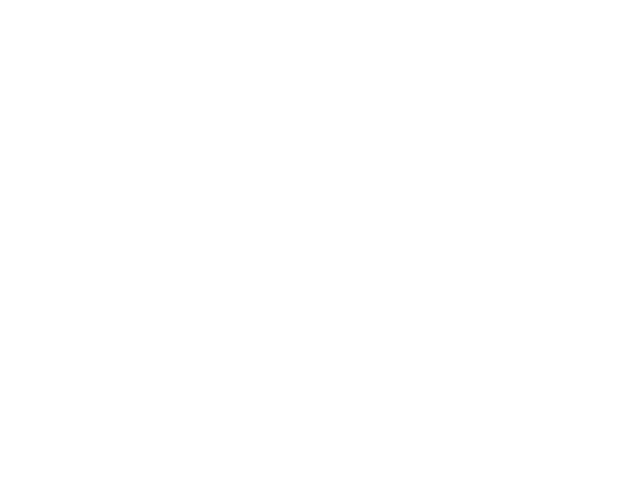

In [40]:
plot = Plot(scenes)
plot.draw()